# The Characteristics of a Tennis Match Winner

### Group 38 Project Proposal

#### Introduction
Likelihood of winning a game of tennis can be divided into four categories: strategy, technique, physical conditions, and mental game. While all components contribute to a win, we aim to test the importance of physical conditions by predicting the rank of a tennis player based on attributes such as height, age, and hand-dominance. To answer this question we will use data from the dataset “player_stats.csv”, which describes the player statistics for the top 500 tennis players worldwide.

#### Preliminary exploratory data analysis

##### Methods
The columns we will be using for this project are “Height”, “Plays” (hand-dominance), and “Age” to predict "Current Rank". We chose to use "Current Rank" rather than "Best Rank" because it is reflective of their current physical conditions and skill level as well as to avoid duplicate rankings in the dataset. We will be using a scatter plot to visualise the results by plotting players’ heights, hand-dominance, and age (on the x-axis) with their rankings (on the y-axis). There will be 3 separate scatter plots, one for each respective variable. We will be combining the results from the graphs into a linear regression model to answer our predictive question. 

##### Expected outcomes and significance:

- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

#### Preliminary exploratory data analysis:

In [3]:
# Setup
set.seed(3)

library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(ISLR)
#library(themis)
options(repr.matrix.max.rows = 6)

#### First, we will tidy up our data:

In [4]:
# Load the data from the web
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
tennis <- read_csv(url) 

# Fix column names
colnames(tennis) <- make.names(colnames(tennis))

# Select only relevant columns to our study.

tennis <- select(tennis, c(Age, Plays, Current.Rank, Height))



head(tennis)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Plays,Current.Rank,Height
<chr>,<chr>,<chr>,<chr>
26 (25-04-1993),Right-handed,378 (97),NA
18 (22-12-2001),Left-handed,326 (119),NA
32 (03-11-1987),Right-handed,178 (280),185 cm
21 (29-05-1998),Right-handed,236 (199),NA
27 (21-10-1992),Right-handed,183 (273),193 cm
22 (11-02-1997),Right-handed,31 (1398),NA


In [28]:
# Now we will tidy up our data further by getting rid of unnecessary information in certain columns (ex. dates, "cm", extra number next to rank)

# Separate unnecessary information from their original column into a new column
tennis <- separate(tennis, col = Age, into = c("Age", "x"), sep = " ", convert = TRUE) |> 
          separate(col = Current.Rank, into = c("Current.Rank", "y"), sep = " ", convert = TRUE) |>
          separate(col = Height, into = c("Height", "z"), sep = " ", convert = TRUE) 

# Delete unnecessary columns
tennis <- select(tennis, -c(x, y, z)) 

#Here we will mutate Plays to a factor so we can visulaize it easier 
tennis_mutate <- tennis |>
mutate(Plays = as_factor(Plays))




head(tennis_mutate)

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 499 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 495 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 115 rows [3, 5, 16, 21, 22, 23, 30, 35, 40, 41, 45, 47, 48, 50, 53, 57, 58, 63, 66, 69, ...].”


Age,Plays,Current.Rank,Height
<int>,<fct>,<int>,<int>
26,Right-handed,378,NA
18,Left-handed,326,NA
32,Right-handed,178,185
21,Right-handed,236,NA
27,Right-handed,183,193
22,Right-handed,31,NA


#### Summary of Training Data
Now, we will summarize our training data to report the mean of our numeric predictors (Age and Height), as well as the number of missing observations and total observations. We also chose to remove the Height predictor in this section due to too many missing observations. 

In [50]:
# Split our data into training and testing
set.seed(1234) #DO NOT REMOVE
tennis_split <- initial_split(tennis_mutate %>% select(-Height), prop = 0.7, strata = Current.Rank) 
tennis_train <- training(tennis_split) 
tennis_test <- testing(tennis_split)

missing_obs <- sum(apply(tennis_train, 1, function(x) any(is.na(x)))) # Used to find the number of missing observations  
                         
total_obs <- nrow(tennis_train) # Used to find the total number of observations
                         
#mean_Height <- mean(tennis_train$Height, na.rm = TRUE) # Used to find the mean Height

#mean_Age <- mean(tennis_train$Age, na.rm = TRUE) # Used to find the mean Age

          
#tab <- matrix(c(mean_Age, mean_Height, missing_obs, total_obs), ncol=4, byrow=TRUE) #used to create a table to express the answers.
#colnames(tab) <- c('Mean Age','Mean Height','Missing Observations', 'Number of Rows')
#rownames(tab) <- c('Value')
#tab <- as.table(tab)
#tab





#### Distribution of Predictors
Using the training data, we can create 3 graphs to visualize the distributions of each predictor variable used in our analysis. 

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'Height' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print(

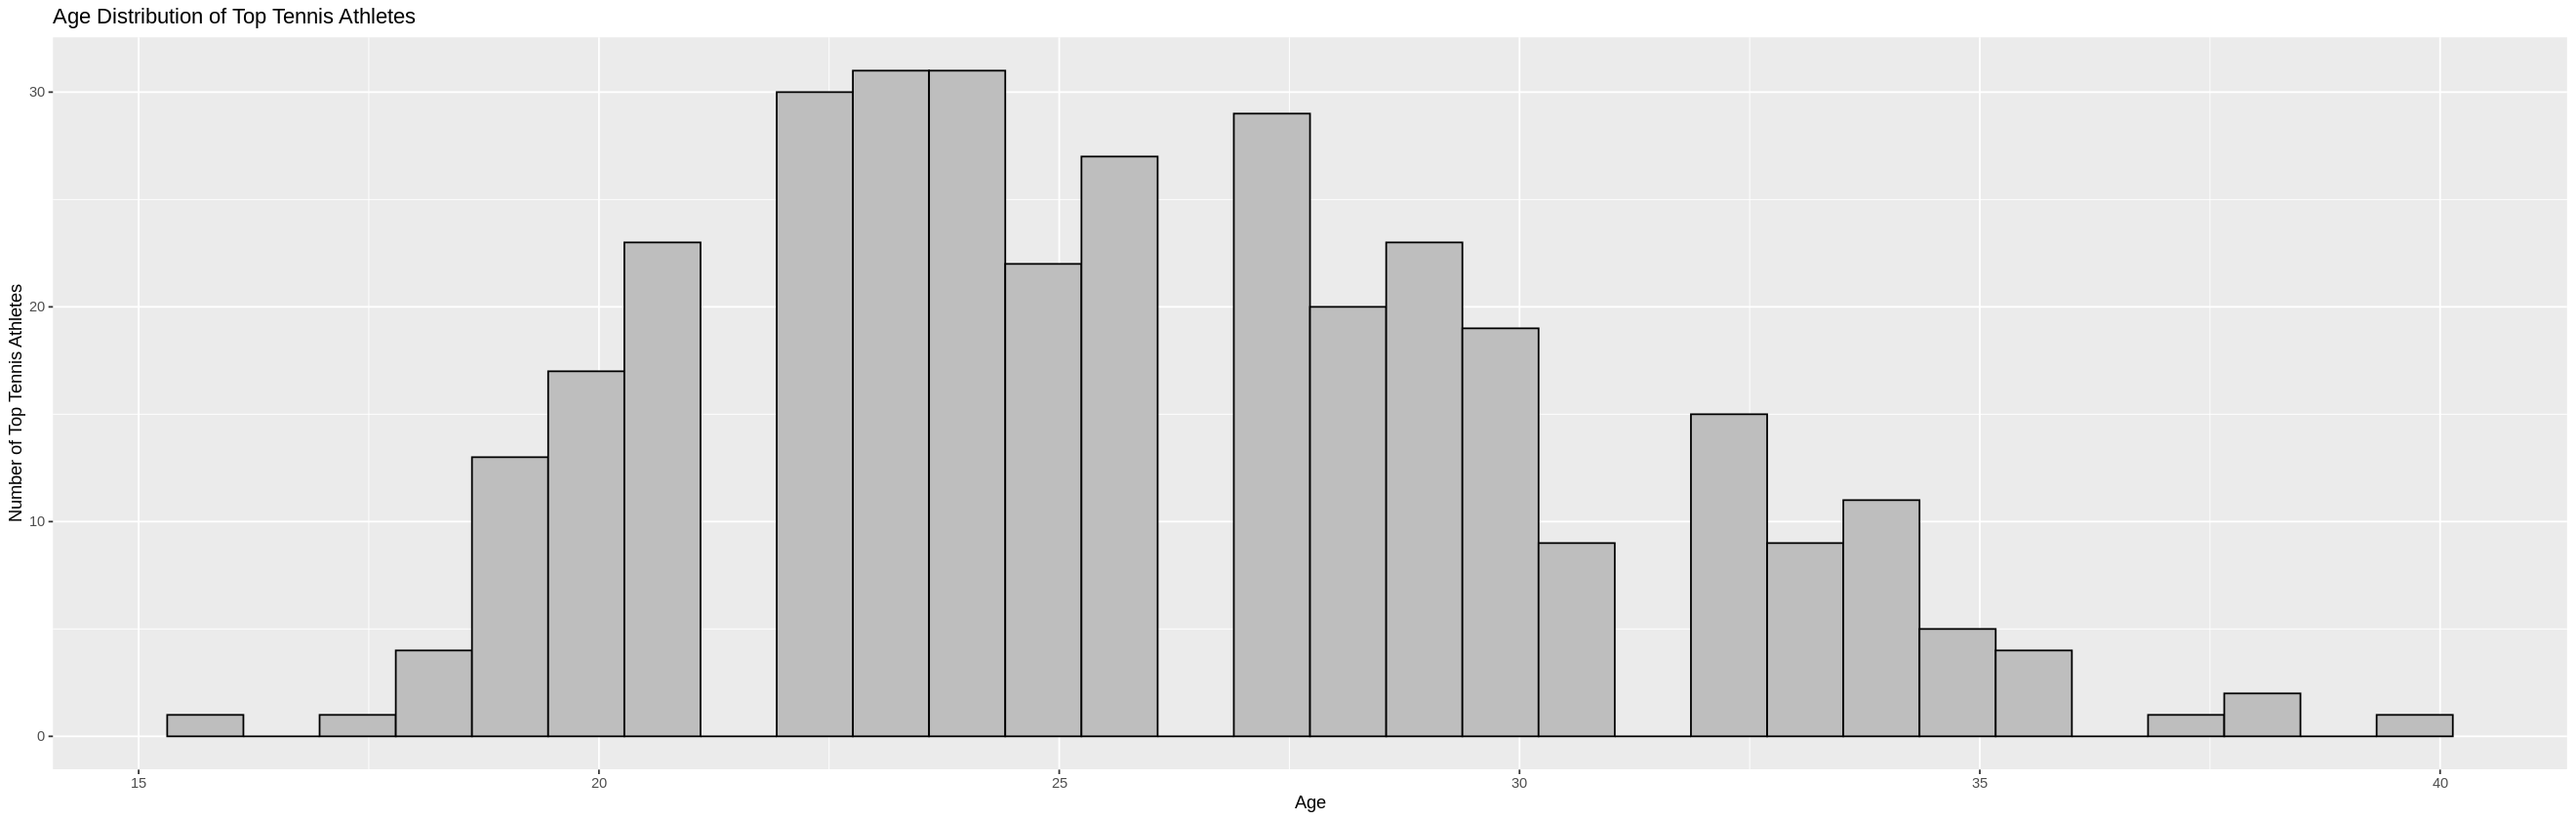

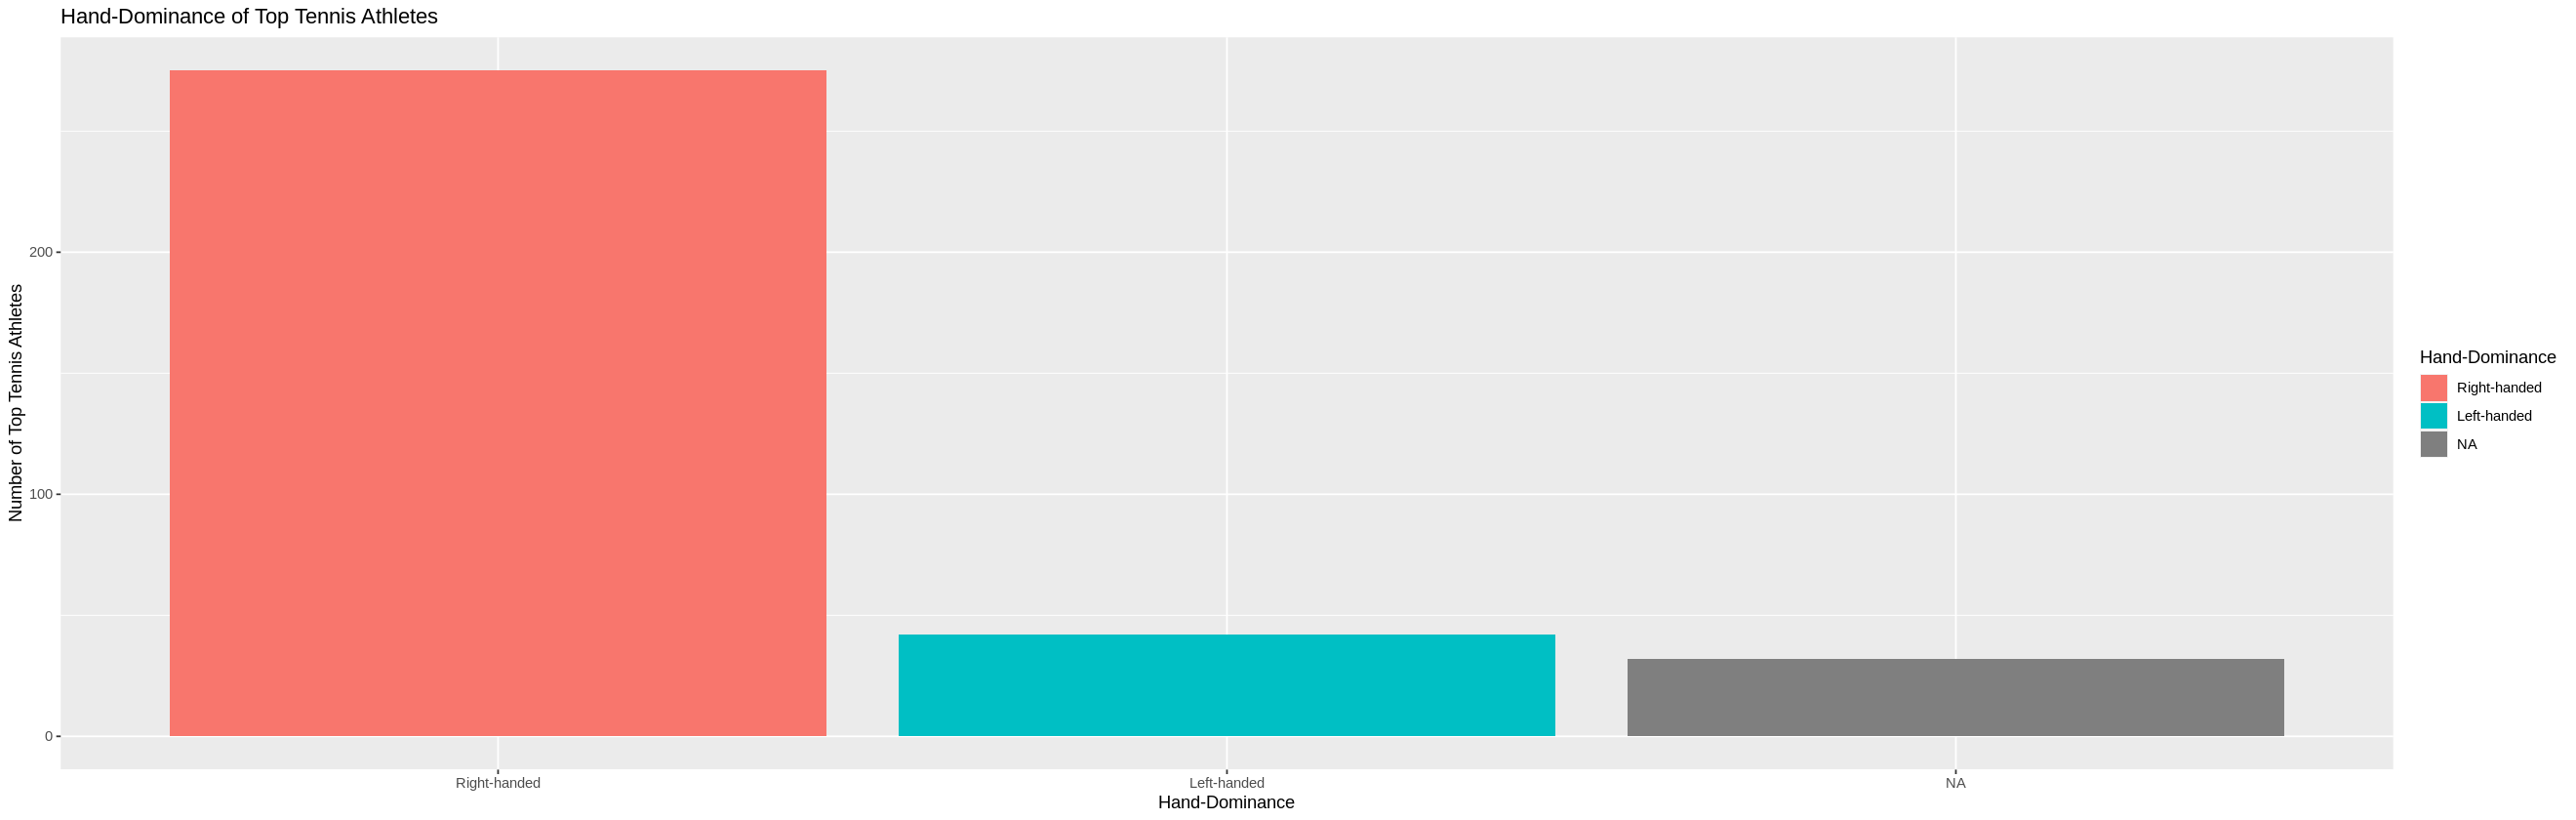

In [51]:
# Create a histogram to show the Height distribution
height_plot <- ggplot(tennis_train, aes(x = Height)) +
  geom_histogram(colour = 1, fill = "grey", bins = 30) +
  xlab("Height (in cm)") +
  ylab("Number of Top Tennis Athletes") +
  ggtitle("Height Distribution of Top Tennis Athletes")

# Create a histogram to show the Age distribution
age_plot <- ggplot(tennis_train, aes(x = Age)) +
  geom_histogram(colour = 1, fill = "grey", bins = 30) +
  xlab("Age") +
  ylab("Number of Top Tennis Athletes") +
  ggtitle("Age Distribution of Top Tennis Athletes")

# Create a bar graph to compare right and left Hand-Dominance
hand_data <- group_by(tennis_train, Plays) |> summarize(count = n()) 

hand_bar <- ggplot(hand_data, aes(x = Plays, y = count, fill = Plays)) +
  geom_bar(stat = "identity") +
  xlab("Hand-Dominance") +
  ylab("Number of Top Tennis Athletes") +
  labs(fill = "Hand-Dominance") +
  ggtitle("Hand-Dominance of Top Tennis Athletes")

height_plot
age_plot
hand_bar

Age,Plays,Current.Rank
<int>,<fct>,<int>
22,Right-handed,31
20,Right-handed,104
19,Right-handed,22
⋮,⋮,⋮
25,Right-handed,486
23,Left-handed,429
32,Right-handed,416


Warning message:
“Removed 1 rows containing non-finite values (stat_density).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 33 rows containing missing values”
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 32 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing non-finite values (stat_density).”


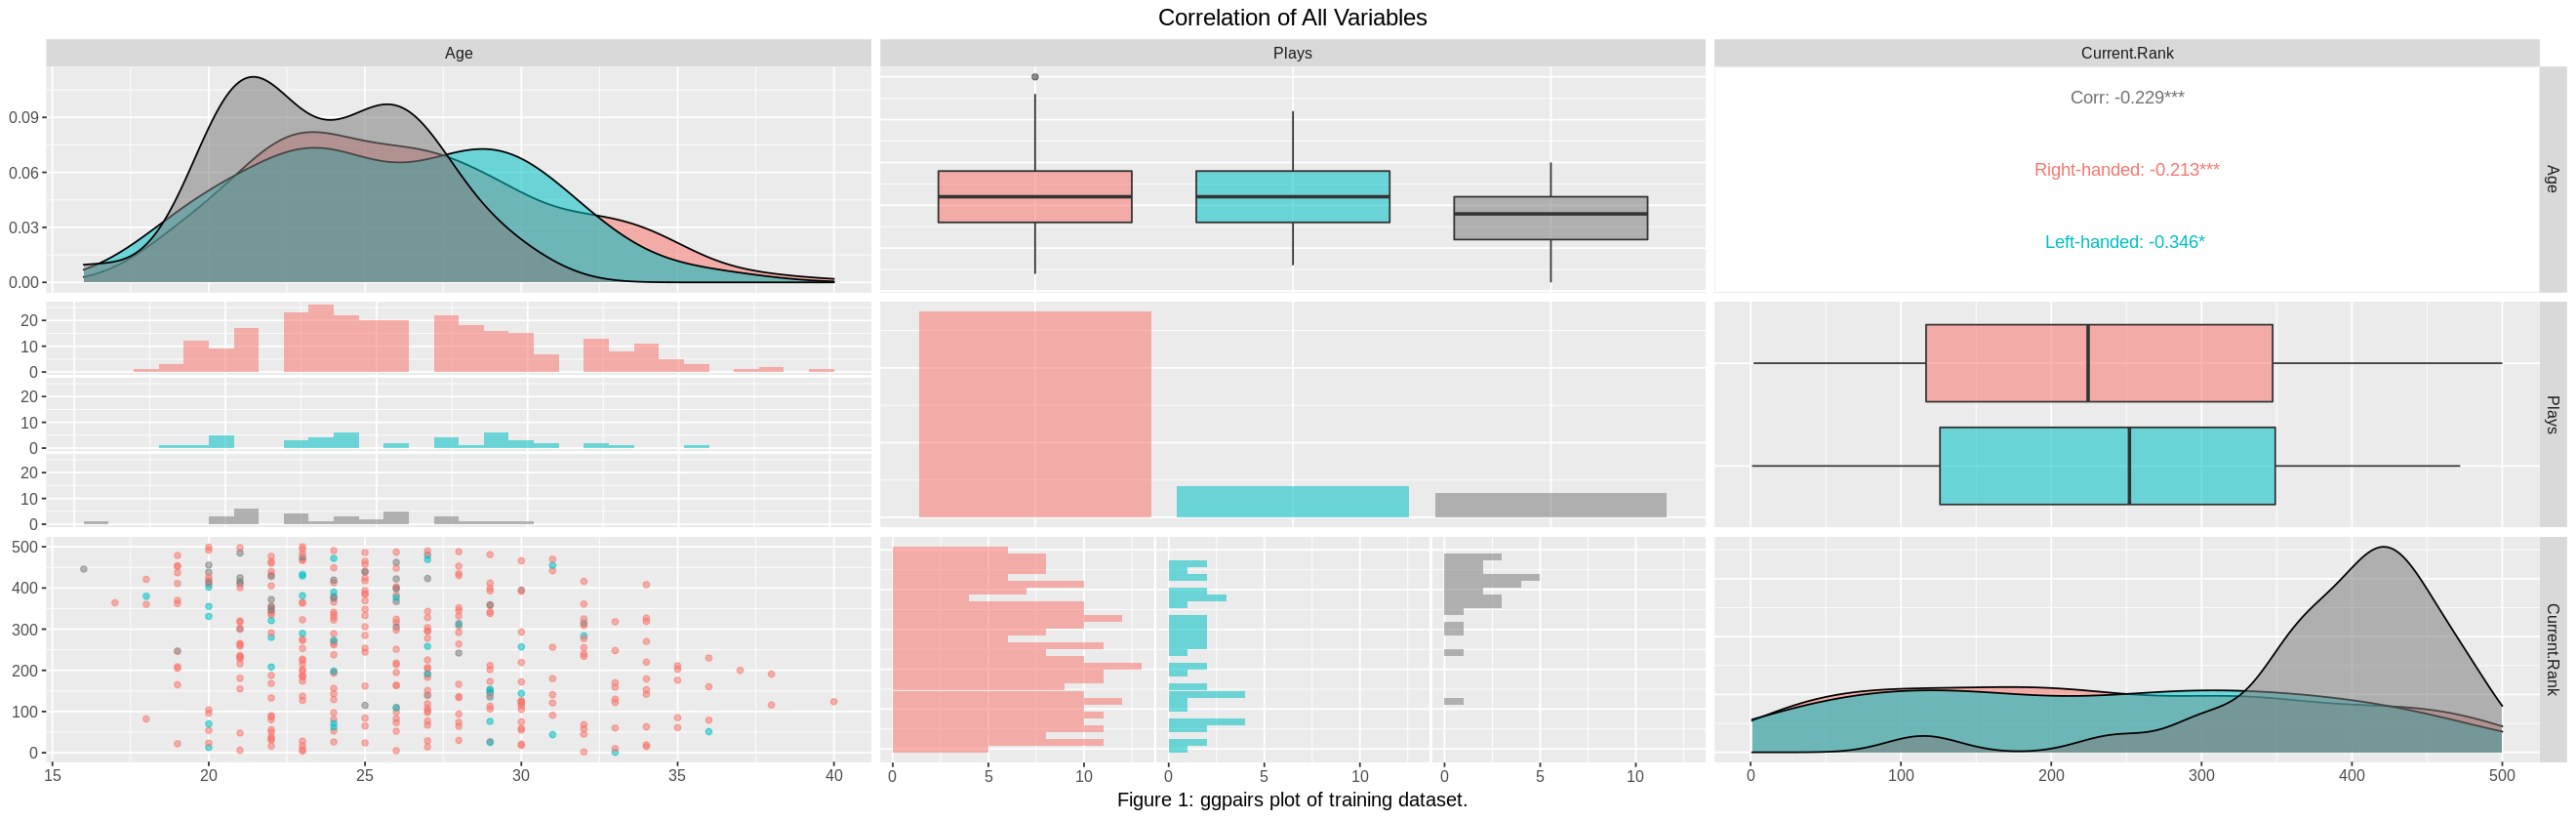

In [52]:
#quadrants <- split(tennis_train, 4)
na.omit(tennis_train)

tennis_exploratory <- ggpairs(tennis_train, mapping = aes(color = Plays, alpha = 0.5), lower=list(combo=wrap("facethist", bins = 30))) +
    labs(caption = "Figure 1: ggpairs plot of training dataset.") +
   ggtitle("Correlation of All Variables") +
    theme(text = element_text(size = 12),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(hjust = 0.5, size = 12))

tennis_exploratory


In [70]:
ranks_list <- tennis_train$Current.Rank

tennis_train %>%
mutate(binned_cr = case_when(`Current.Rank` >= quantile(ranks_list,0.75, na.rm = T) ~ "Lowest_quartile",
                             `Current.Rank` >= quantile(ranks_list,0.5, na.rm = T) ~ "Medium_low",
                             `Current.Rank` >= quantile(ranks_list,0.25, na.rm = T) ~ "Medium_high",
                             `Current.Rank` >= quantile(ranks_list,0, na.rm = T) ~ "Top_quartile",
                             TRUE ~ "Other"))

quantile(ranks_list,0.75, na.rm = T)

Age,Plays,Current.Rank,binned_cr
<int>,<fct>,<int>,<chr>
22,Right-handed,31,Top_quartile
20,Right-handed,104,Top_quartile
19,Right-handed,22,Top_quartile
⋮,⋮,⋮,⋮
23,Left-handed,429,Lowest_quartile
32,Right-handed,416,Lowest_quartile
24,NA,419,Lowest_quartile


75% 
372

# Data Analysis
### Fitting a linear regression model
Using our training data, in the following code we fit a linear regression model.

In [44]:
lm_spec <- linear_reg() |> 
set_engine("lm") |>
set_mode("regression")

tennis_recipe <- recipe(Current.Rank ~., data = tennis_train)

tennis_fit <- workflow() |>
add_model(lm_spec) |>
add_recipe(tennis_recipe) |>
fit(data = tennis_train)

tennis_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)               Age  PlaysLeft-handed  
         422.839            -7.111            -5.190  


### Calculating an RMSE
In the next section, we calculate and RMSE to asses how well the model fits the data.

In [45]:
tennis_rmse <- tennis_fit |>
predict(tennis_train) |>
bind_cols(tennis_train) |>
metrics(truth = Current.Rank, estimate = .pred) |>
filter(.metric == "rmse") |>
pull()

print(tennis_rmse)

[1] 138.137


### Equation of our model's line

$y = 422.839 + -7.111 Age + -5.190 Plays(Left-handed)$

### Calculating RMSPE
In this section, we make a real prediction using test data.

Warning message:
“Removed 15 rows containing missing values (geom_point).”


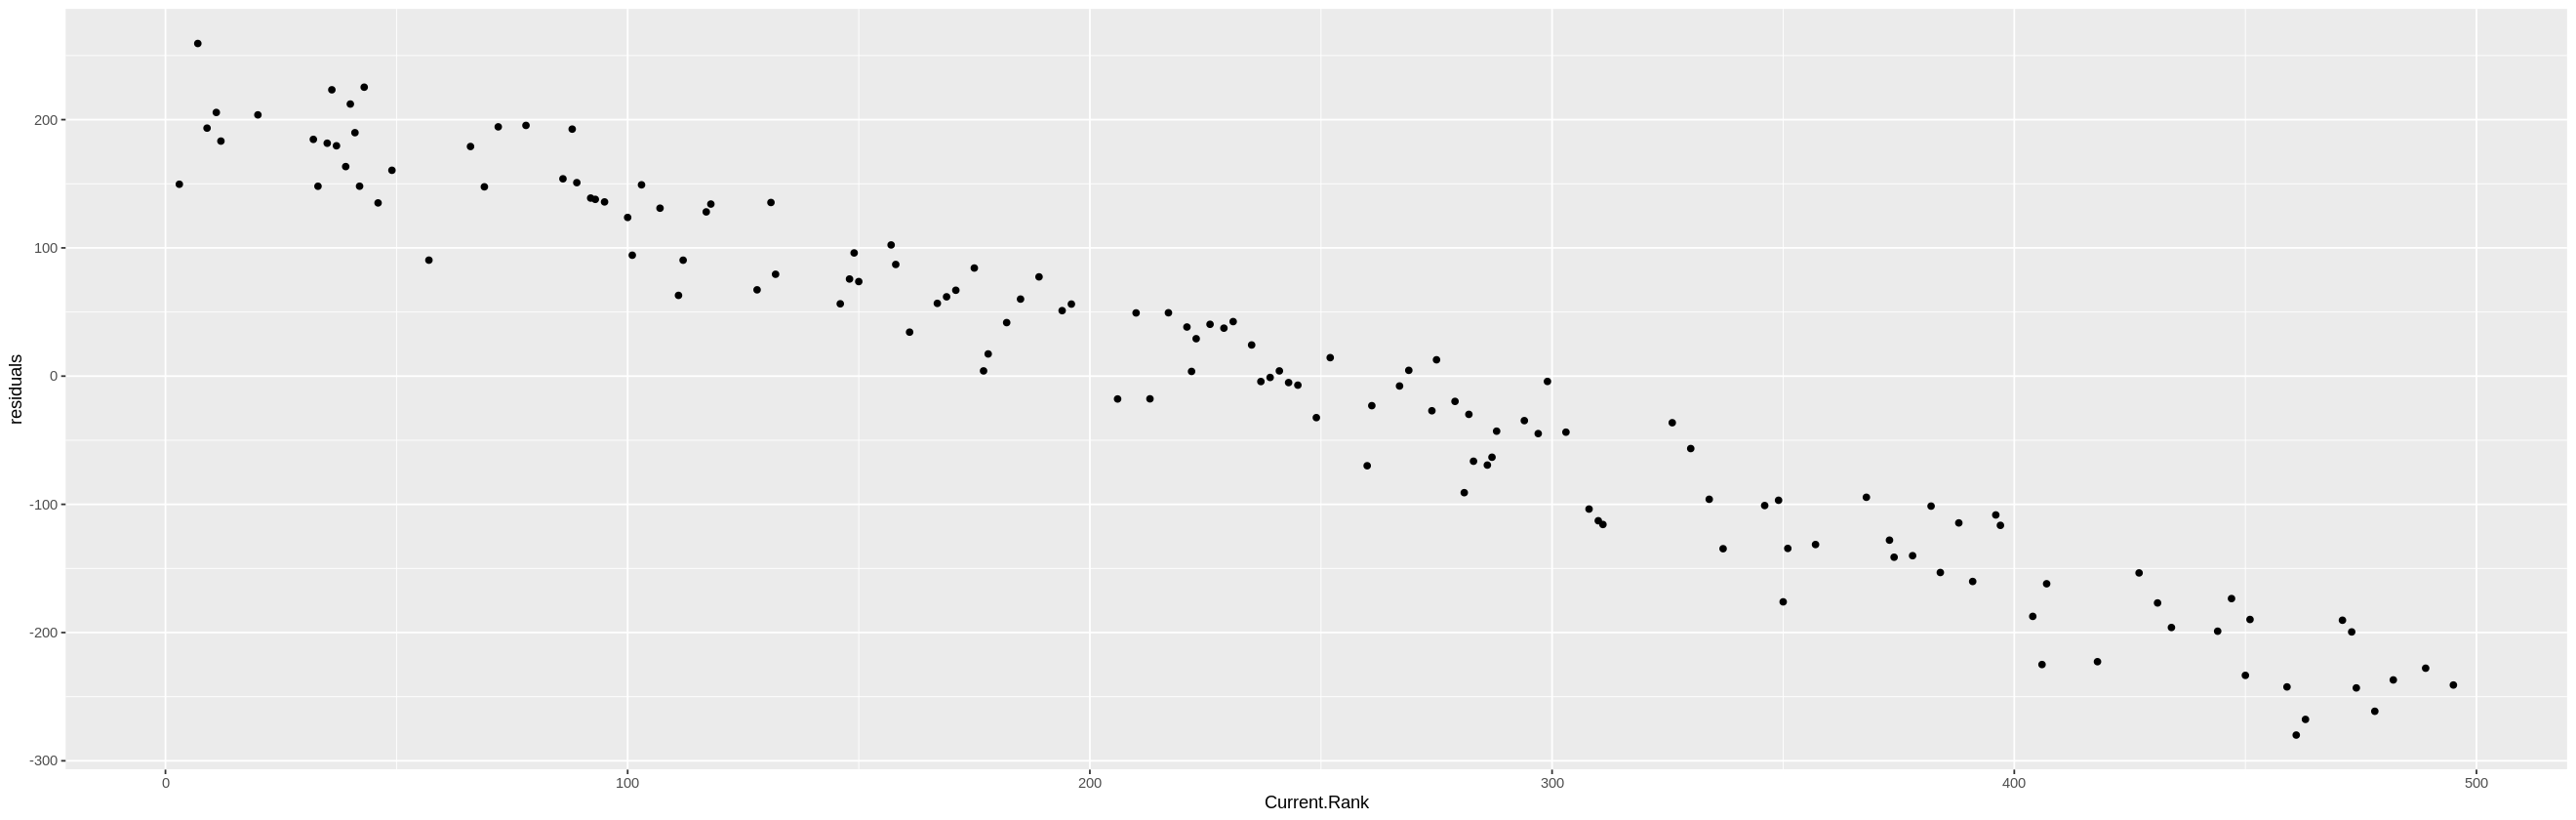

In [49]:
tennis_test_results <- tennis_fit |>
predict(tennis_test) |>
bind_cols(tennis_test) 

tennis_rmspe <- tennis_test_results |>
metrics(truth = Current.Rank, estimate = .pred) |>
filter(.metric == "rmse") |>
pull()

tennis_test_results %>%
mutate(residuals = `.pred` - `Current.Rank`) %>%
ggplot()+
geom_point(aes(x = `Current.Rank`, y = residuals))

## Visualizing our data
We will plot the varibales we are interest in, current rank, agaisnt our three other predictor variables.

In [57]:
options(repr.plot.width = 22)

Rank_v_Age <- ggplot(tennis_train, aes(x = Age, y = Current.Rank)) +
  geom_point() +
  xlab("Age (Years)") +
  ylab("Current Rank") +
  scale_y_continuous(labels = dollar_format()) +
  geom_smooth(method = "lm", se = FALSE) + 
theme(text = element_text(size = 12))

Rank_v_hand <- ggplot(tennis_train, aes(x = Plays,)) +
  geom_histogram() +
  xlab("Hand Dominance") +
  ylab("Current Rank") +
  scale_y_continuous(labels = dollar_format()) +
  geom_smooth(method = "lm", se = FALSE) + 
  theme(text = element_text(size = 12))

tennis_panel <- plot_grid(Rank_v_Age, Rank_v_hand, ncol = 2)
tennis_panel

Rank_v_Hand
#test

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


ERROR: [1m[33mError[39m in [1m[1m`f()`:[22m
[33m![39m StatBin requires a continuous x variable: the x variable is discrete.Perhaps you want stat="count"?
